<a href="https://colab.research.google.com/github/rssubramaniyan1/EVA8/blob/main/EVA8_Assignment5_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignment5**

**Objective**
> Write a single model.py file that includes GN/LN/BN and takes an argument to decide which normalization to include

> Write a single notebook file to run all the 3 models above for 20 epochs each

> Create these graphs:
>>   Graph 1: Test/Validation Loss for all 3 models together
>>   Graph 2: Test/Validation Accuracy for 3 models together

________________________________________________________________________________

This assignment has two scripts:


1.   EVA8_Assignment5_model
2.   EVA8_Assignment_main

**EVA8_Assignment5_model**

>This script defines a class for 3 normalization approaches- Layer/Group/Batch

**EVA8_Assignment_main**

>This script uses the network from Assignment 4 (Best model - Attempt2) and calls the normalization scrpit(EVA8_Assignment5_model)

> In a for loop network is run for all 3 normalization methods , 20 epochs each

> Plot the accuracy of 3 normalization methods

> Plot the loss of 3 normalization methods

> Plot the mis classified images from 3 normalization methods





In [1]:
!cp /content/drive/MyDrive/Colab\ Notebooks/EVA8_Assignment5_model.ipynb /content 

In [2]:
%run /content/drive/MyDrive/Colab\ Notebooks/EVA8_Assignment5_model.ipynb import * # importing the normalization class function to be used in the main code

In [3]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt



# Defininig the Train and Test functions

>Tweaked the test function to return aggregate accuracy, loss and the misclassified images

In [4]:

torch.manual_seed(1)
batch_size = 128
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                        #transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.4f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []
    misclassified_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # find misclassified images
            misclassified_mask = pred.squeeze() != target
            misclassified_images.append(data[misclassified_mask])
            misclassified_labels.append(pred[misclassified_mask])

    test_loss /= len(test_loader.dataset)
    test_acc_1 = 100. * correct / len(test_loader.dataset)
    # get the index of the misclassified images
    # concatenate misclassified images and labels
    misclassified_images = torch.cat(misclassified_images, dim=0)
    misclassified_labels = torch.cat(misclassified_labels, dim=0)

    # store
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, test_acc_1,misclassified_images[:10], misclassified_labels[:10]



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# The network

>This is the same as Assignment 4 - Attempt2

In [5]:

class Net(nn.Module):
    #norm_type = norm_type
    def __init__(self):
        super(Net, self).__init__()
        self.norm_type = norm_type
        # CONV BLOCK 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),  # input size 28x28x1, output size 28x28x8, RF 3x3
            nn.ReLU(),
            # pass the norm_type as an argument
            nn.BatchNorm2d(8) if self.norm_type == 'BN' else nn.GroupNorm(2, 8) if self.norm_type == 'GN' else
            nn.LayerNorm([8, 28, 28]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1),

            nn.Conv2d(8, 10, 3, padding=1),  # input size 28x28x8, output size 28x28x10, RF 5x5
            nn.ReLU(),
            nn.BatchNorm2d(10) if self.norm_type == 'BN' else nn.GroupNorm(2, 10) if self.norm_type == 'GN' else
            nn.LayerNorm([10, 28, 28]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1),

            nn.Conv2d(10, 12, 3, padding=1),  # input size 28x28x10, output size 28x28x12, RF 7x7
            nn.ReLU(),
            nn.BatchNorm2d(12) if self.norm_type == 'BN' else nn.GroupNorm(2, 12) if self.norm_type == 'GN' else
            nn.LayerNorm([12, 28, 28]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1)

        )

        # MAX POOL - 1

        self.pool1 = nn.MaxPool2d(2, 2)  # input size 28x28x12, output size 14x14x12, RF 7x7

        # CONV BLOCK 2

        self.conv2 = nn.Sequential(
            nn.Conv2d(12, 16, 3, padding=1),  # input size 14x14x12, output size 14x14x16, RF 14x14
            nn.ReLU(),
            nn.BatchNorm2d(16) if self.norm_type == 'BN' else nn.GroupNorm(2, 16) if self.norm_type == 'GN' else
            nn.LayerNorm([16, 14, 14]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1),

            nn.Conv2d(16, 16, 3, padding=1),  # input size 14x14x16, output size 14x14x16, RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(16) if self.norm_type == 'BN' else nn.GroupNorm(2, 16) if self.norm_type == 'GN' else
            nn.LayerNorm([16, 14, 14]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1)
        )

        # MAX POOL -2

        self.pool2 = nn.MaxPool2d(2, 2)  # input size 14x14x16, output size 7x7x16, RF 16x16

        # CONV BLOCK 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 8, 1, padding=0),  # input size 7x7x16, output size 7x7x8, RF 32x32
            nn.ReLU(),
            nn.BatchNorm2d(8) if self.norm_type == 'BN' else nn.GroupNorm(2, 8) if self.norm_type == 'GN' else
            nn.LayerNorm([8, 7, 7]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1),

            nn.Conv2d(8, 10, 3),  # input size 7x7x8, output size 5x5x10, RF 34x34
            nn.ReLU(),
            nn.BatchNorm2d(10) if self.norm_type == 'BN' else nn.GroupNorm(2, 10) if self.norm_type == 'GN' else
            nn.LayerNorm([10, 5, 5]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1),

            nn.Conv2d(10, 12, 3),  # input size 5x5x10, output size 3x3x12, RF 36x36
            nn.ReLU(),
            nn.BatchNorm2d(12) if self.norm_type == 'BN' else nn.GroupNorm(2, 12) if self.norm_type == 'GN' else
            nn.LayerNorm([12, 3, 3]) if self.norm_type == 'LN' else None,
            nn.Dropout(0.1)
        )

        # OUTPUT BLOCK

        self.conv4 = nn.Sequential(
            nn.Conv2d(12, 10, 3)  # input size 3x3x12, output size 1x1x10, RF 38x38
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)

        x = self.conv4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)



# Train the network

>Each model is trained using 3 different normalization method

>Run for 20 Epochs

>The accuracy, loss and misclassified images are stored for plotting

In [6]:
accuracy_ = []
loss_ = []
misc_img = []
misc_img_lab = []

agg_accuracy = {}
agg_loss = {}
misc_img_dict = {}
misc_img_dict_lab = {}

for p in ['LN', 'BN', 'GN']:
    norm_type = p
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    summary(model, input_size=(1, 28, 28))
    print('Norm type: ', norm_type)
    for epoch in range(1, 21):
        print('Epoch: ', epoch)
        train(model, device, train_loader, optimizer, epoch)
        test_loss,test_acc,misc_,misc_lab= test(model, device, test_loader)

        accuracy_.append(test_acc)
        loss_.append(test_loss)
        misc_img.append(misc_)
        misc_img_lab.append(misc_lab)
    agg_accuracy[norm_type] = accuracy_
    agg_loss[norm_type] = loss_
    misc_img_dict[norm_type] = misc_img
    misc_img_dict_lab[norm_type] = misc_img_lab

    accuracy_ = []
    loss_ = []
    misc_img = []
    misc_img_lab = []

# Plotting the results for accuracy and loss for each norm type



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         LayerNorm-3            [-1, 8, 28, 28]          12,544
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             730
              ReLU-6           [-1, 10, 28, 28]               0
         LayerNorm-7           [-1, 10, 28, 28]          15,680
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 12, 28, 28]           1,092
             ReLU-10           [-1, 12, 28, 28]               0
        LayerNorm-11           [-1, 12, 28, 28]          18,816
          Dropout-12           [-1, 12, 28, 28]               0
        MaxPool2d-13           [-1, 12, 14, 14]               0
           Conv2d-14           [-1, 16,

loss=0.2418324500322342 batch_id=468 Accuracy=90.3433: 100%|██████████| 469/469 [00:24<00:00, 18.90it/s]



Test set: Average loss: 0.0741, Accuracy: 9762/10000 (97.6200%)

Epoch:  2


loss=0.2414313703775406 batch_id=468 Accuracy=96.6783: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]



Test set: Average loss: 0.0468, Accuracy: 9856/10000 (98.5600%)

Epoch:  3


loss=0.08209209889173508 batch_id=468 Accuracy=97.3583: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]



Test set: Average loss: 0.0497, Accuracy: 9857/10000 (98.5700%)

Epoch:  4


loss=0.2070518136024475 batch_id=468 Accuracy=97.5267: 100%|██████████| 469/469 [00:23<00:00, 19.62it/s]



Test set: Average loss: 0.0418, Accuracy: 9865/10000 (98.6500%)

Epoch:  5


loss=0.10869833827018738 batch_id=468 Accuracy=97.9533: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]



Test set: Average loss: 0.0293, Accuracy: 9912/10000 (99.1200%)

Epoch:  6


loss=0.02628938853740692 batch_id=468 Accuracy=98.0733: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]



Test set: Average loss: 0.0431, Accuracy: 9861/10000 (98.6100%)

Epoch:  7


loss=0.025401877239346504 batch_id=468 Accuracy=98.1617: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]



Test set: Average loss: 0.0275, Accuracy: 9906/10000 (99.0600%)

Epoch:  8


loss=0.028425320982933044 batch_id=468 Accuracy=98.1800: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]



Test set: Average loss: 0.0233, Accuracy: 9917/10000 (99.1700%)

Epoch:  9


loss=0.09686997532844543 batch_id=468 Accuracy=98.3833: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]



Test set: Average loss: 0.0225, Accuracy: 9923/10000 (99.2300%)

Epoch:  10


loss=0.007538978476077318 batch_id=468 Accuracy=98.4283: 100%|██████████| 469/469 [00:23<00:00, 20.08it/s]



Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.2300%)

Epoch:  11


loss=0.08809300512075424 batch_id=468 Accuracy=98.4333: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]



Test set: Average loss: 0.0212, Accuracy: 9928/10000 (99.2800%)

Epoch:  12


loss=0.12292858958244324 batch_id=468 Accuracy=98.5183: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.3300%)

Epoch:  13


loss=0.08418122678995132 batch_id=468 Accuracy=98.5733: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.3400%)

Epoch:  14


loss=0.045574966818094254 batch_id=468 Accuracy=98.6517: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]



Test set: Average loss: 0.0235, Accuracy: 9920/10000 (99.2000%)

Epoch:  15


loss=0.03312898054718971 batch_id=468 Accuracy=98.6567: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]



Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.2500%)

Epoch:  16


loss=0.03227166458964348 batch_id=468 Accuracy=98.6933: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]



Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.3400%)

Epoch:  17


loss=0.03660300374031067 batch_id=468 Accuracy=98.6833: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]



Test set: Average loss: 0.0199, Accuracy: 9925/10000 (99.2500%)

Epoch:  18


loss=0.06254536658525467 batch_id=468 Accuracy=98.6800: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]



Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.3800%)

Epoch:  19


loss=0.05728333070874214 batch_id=468 Accuracy=98.6983: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]



Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.3000%)

Epoch:  20


loss=0.033771004527807236 batch_id=468 Accuracy=98.7850: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0188, Accuracy: 9929/10000 (99.2900%)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             730
              ReLU-6           [-1, 10, 28, 28]               0
       BatchNorm2d-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 12, 28, 28]           1,092
             ReLU-10           [-1, 12, 28, 28]               0
      BatchNorm2d-11           [-1, 12, 28, 28]              24
          Dropout-12           [-1, 12, 28, 28]               0
        MaxPool2d-13           [-1, 1

loss=0.059585656970739365 batch_id=468 Accuracy=90.9933: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]



Test set: Average loss: 0.0714, Accuracy: 9759/10000 (97.5900%)

Epoch:  2


loss=0.049302008002996445 batch_id=468 Accuracy=96.8183: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]



Test set: Average loss: 0.0517, Accuracy: 9826/10000 (98.2600%)

Epoch:  3


loss=0.030923468992114067 batch_id=468 Accuracy=97.5950: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]



Test set: Average loss: 0.0360, Accuracy: 9876/10000 (98.7600%)

Epoch:  4


loss=0.11301955580711365 batch_id=468 Accuracy=97.8500: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]



Test set: Average loss: 0.0348, Accuracy: 9890/10000 (98.9000%)

Epoch:  5


loss=0.019022947177290916 batch_id=468 Accuracy=98.0833: 100%|██████████| 469/469 [00:22<00:00, 20.69it/s]



Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.0700%)

Epoch:  6


loss=0.03336955979466438 batch_id=468 Accuracy=98.1383: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]



Test set: Average loss: 0.0312, Accuracy: 9898/10000 (98.9800%)

Epoch:  7


loss=0.10743006318807602 batch_id=468 Accuracy=98.3617: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]



Test set: Average loss: 0.0296, Accuracy: 9902/10000 (99.0200%)

Epoch:  8


loss=0.04745146632194519 batch_id=468 Accuracy=98.4883: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]



Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.1800%)

Epoch:  9


loss=0.0025628467556089163 batch_id=468 Accuracy=98.5200: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.0280, Accuracy: 9911/10000 (99.1100%)

Epoch:  10


loss=0.04648119583725929 batch_id=468 Accuracy=98.5283: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.2200%)

Epoch:  11


loss=0.11180434376001358 batch_id=468 Accuracy=98.5267: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0279, Accuracy: 9909/10000 (99.0900%)

Epoch:  12


loss=0.08506800979375839 batch_id=468 Accuracy=98.6233: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]



Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.2400%)

Epoch:  13


loss=0.057275015860795975 batch_id=468 Accuracy=98.6333: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.2700%)

Epoch:  14


loss=0.0057098413817584515 batch_id=468 Accuracy=98.6650: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]



Test set: Average loss: 0.0240, Accuracy: 9918/10000 (99.1800%)

Epoch:  15


loss=0.06913454830646515 batch_id=468 Accuracy=98.6983: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]



Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.3400%)

Epoch:  16


loss=0.1353420466184616 batch_id=468 Accuracy=98.7450: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]



Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.2100%)

Epoch:  17


loss=0.027931516990065575 batch_id=468 Accuracy=98.7167: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.2500%)

Epoch:  18


loss=0.006174454465508461 batch_id=468 Accuracy=98.8083: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]



Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.3200%)

Epoch:  19


loss=0.004526423290371895 batch_id=468 Accuracy=98.7717: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.3900%)

Epoch:  20


loss=0.004851223900914192 batch_id=468 Accuracy=98.7967: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]



Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.3700%)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         GroupNorm-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             730
              ReLU-6           [-1, 10, 28, 28]               0
         GroupNorm-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 12, 28, 28]           1,092
             ReLU-10           [-1, 12, 28, 28]               0
        GroupNorm-11           [-1, 12, 28, 28]              24
          Dropout-12           [-1, 12, 28, 28]               0
        MaxPool2d-13           [-1, 1

loss=0.1563582569360733 batch_id=468 Accuracy=89.9567: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0839, Accuracy: 9714/10000 (97.1400%)

Epoch:  2


loss=0.08354536443948746 batch_id=468 Accuracy=96.5633: 100%|██████████| 469/469 [00:23<00:00, 19.79it/s]



Test set: Average loss: 0.0511, Accuracy: 9834/10000 (98.3400%)

Epoch:  3


loss=0.16162587702274323 batch_id=468 Accuracy=97.3000: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]



Test set: Average loss: 0.0403, Accuracy: 9867/10000 (98.6700%)

Epoch:  4


loss=0.09548694640398026 batch_id=468 Accuracy=97.6500: 100%|██████████| 469/469 [00:23<00:00, 20.07it/s]



Test set: Average loss: 0.0343, Accuracy: 9877/10000 (98.7700%)

Epoch:  5


loss=0.13177581131458282 batch_id=468 Accuracy=97.9133: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.1500%)

Epoch:  6


loss=0.019029421731829643 batch_id=468 Accuracy=98.0617: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]



Test set: Average loss: 0.0255, Accuracy: 9915/10000 (99.1500%)

Epoch:  7


loss=0.10086920857429504 batch_id=468 Accuracy=98.1250: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]



Test set: Average loss: 0.0288, Accuracy: 9913/10000 (99.1300%)

Epoch:  8


loss=0.06683267652988434 batch_id=468 Accuracy=98.2367: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0290, Accuracy: 9910/10000 (99.1000%)

Epoch:  9


loss=0.02752249501645565 batch_id=468 Accuracy=98.3283: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]



Test set: Average loss: 0.0230, Accuracy: 9936/10000 (99.3600%)

Epoch:  10


loss=0.043209318071603775 batch_id=468 Accuracy=98.4317: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]



Test set: Average loss: 0.0236, Accuracy: 9932/10000 (99.3200%)

Epoch:  11


loss=0.13539136946201324 batch_id=468 Accuracy=98.4517: 100%|██████████| 469/469 [00:22<00:00, 21.28it/s]



Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.2400%)

Epoch:  12


loss=0.10936679691076279 batch_id=468 Accuracy=98.4367: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0237, Accuracy: 9922/10000 (99.2200%)

Epoch:  13


loss=0.052460864186286926 batch_id=468 Accuracy=98.5267: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]



Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.3600%)

Epoch:  14


loss=0.0033571578096598387 batch_id=468 Accuracy=98.5317: 100%|██████████| 469/469 [00:23<00:00, 20.08it/s]



Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.3300%)

Epoch:  15


loss=0.010784259997308254 batch_id=468 Accuracy=98.5767: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]



Test set: Average loss: 0.0253, Accuracy: 9919/10000 (99.1900%)

Epoch:  16


loss=0.01479515340179205 batch_id=468 Accuracy=98.6483: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.3000%)

Epoch:  17


loss=0.12950462102890015 batch_id=468 Accuracy=98.6967: 100%|██████████| 469/469 [00:22<00:00, 21.10it/s]



Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.3500%)

Epoch:  18


loss=0.020154574885964394 batch_id=468 Accuracy=98.6000: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]



Test set: Average loss: 0.0192, Accuracy: 9943/10000 (99.4300%)

Epoch:  19


loss=0.033800262957811356 batch_id=468 Accuracy=98.7683: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]



Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.3500%)

Epoch:  20


loss=0.017507709562778473 batch_id=468 Accuracy=98.6817: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]



Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.4200%)



# Visualizing Accuracy vs Epochs

> GN has the highest accuracy

> LN has the lowest 

> There seems to be a tradeoff between accuracy and the choice of normlization method

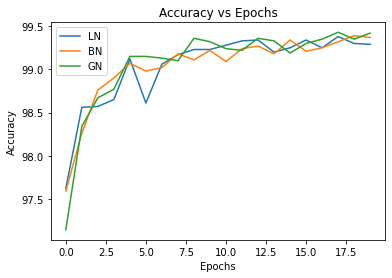

In [8]:
for i in ['LN', 'BN', 'GN']:
    plt.plot(agg_accuracy[i], label=i)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()



# Visualizing Loss vs Epochs

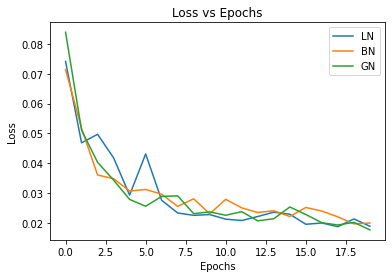

In [9]:

for i in ['LN', 'BN', 'GN']:
    plt.plot(agg_loss[i], label=i)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()



# PLotting Misclassified Images

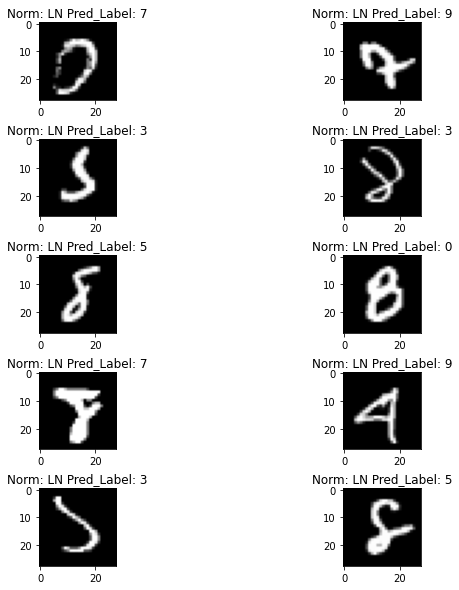

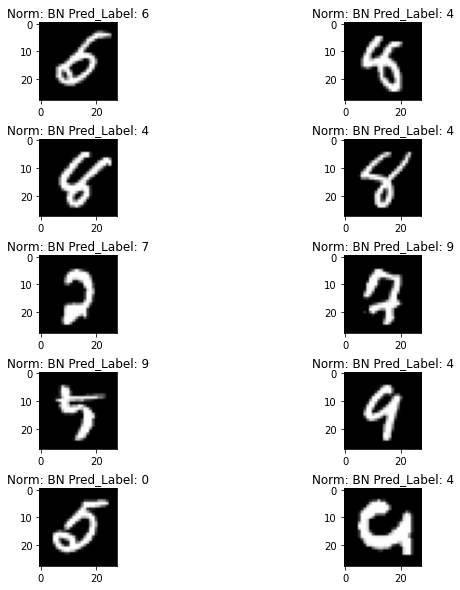

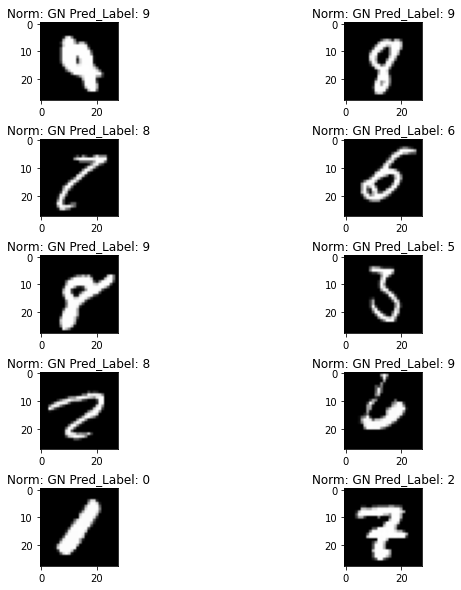

In [11]:
# Plotting the misclassified images for each norm type in a 5x2 grid

for i in ['LN', 'BN', 'GN']:
    fig = plt.figure(figsize=(10, 10))
    for j in range(1, 11):
        # increase the space between subplots
        fig.add_subplot(5, 2, j)
        fig.subplots_adjust(hspace=0.5)
        plt.imshow(misc_img_dict[i][0][j-1].cpu().reshape(28, 28), cmap='gray')
        plt.title('Norm: ' +i+' Pred_Label: ' + str(misc_img_dict_lab[i][0][j-1].item()))
    plt.show()